# Principal Component Analysis with Cancer Data

#### Lab: PGP-AIML, Pune
#### Name: Neeraj Tripathi

In [445]:
#Import all the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import scipy.stats as stats

from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor

from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import cross_validate
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from datetime import datetime
from IPython.display import display
pd.set_option('display.max_columns', None)
%matplotlib inline

## Common Functions

In [326]:
# Function to limit values of outliers to 75 quantile + 1.5 IQR and 25 quantile - 1.5 IQR
def cap_outliers(DataSeries, Ends=0):
    
    # Create a local copy of the dataseries
    varSeries = np.array(DataSeries)
    
    # Calculate and store 25th and 75th percentile
    quant25 = np.quantile(a=varSeries, q=0.25)
    quant75 = np.quantile(a=varSeries, q=0.75)
    
    # Calculate the Inter Quantile Range
    iqr_data = quant75 - quant25
    
    # Upper cap of data series
    cap_upper = quant75 + (1.5 * iqr_data)
    
    # Lower cap of data series
    cap_lower = quant25 - (1.5 * iqr_data)
    
    if (Ends == 0):
        varSeries[varSeries > cap_upper] = cap_upper
        varSeries[varSeries < cap_lower] = cap_lower
    elif (Ends == -1):
        varSeries[varSeries < cap_lower] = cap_lower
    elif (Ends == 1):
        varSeries[varSeries > cap_upper] = cap_upper
    return varSeries

# Function to drop columns from a dataframe having a correlation higher than a threshold
def drop_high_correlations(DataFrame, CorrelationThreshold):
    import pandas as pd
    import numpy as np
    
    df_local = DataFrame.copy(deep=True)
    
    # Create the correlation matrix with absolute values
    corr_matrix = df_local.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of columns with correlation greater than CorrelationThreshold
    to_drop = [column for column in upper.columns if any(upper[column] > CorrelationThreshold)]
    
    # Drop the correlated columns identified above
    df_local.drop(to_drop, axis=1, inplace=True)
    
    return df_local

# Q1. Load the Data file ( Breast Cancer CSV) into Python DataFrame and view top 10 rows

In [109]:
df_bc = pd.read_csv('Cancer.csv')

In [110]:
  # Id columns is to identify rows hence can be skipped in analysis
  # All columns have numerical values
  # Class would be the target variable. Should be removed when PCA is done

In [111]:
df_bc.head()

,ID,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Q2 Print the datatypes of each column and the shape of the dataset. Perform descriptive analysis 

In [112]:
df_bc.shape

(699, 11)

In [113]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           699 non-null    int64 
 1   ClumpThickness               699 non-null    int64 
 2   Cell Size                    699 non-null    int64 
 3   Cell Shape                   699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Normal Nucleoli              699 non-null    int64 
 8   Bland Chromatin              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span>  
- There are 699 rows of data.
- **Info** function shows 699 **_Non-Null_** values.
- The **Head** function shows 'Bare Nuclei' as typical numeric values, however, the info function shows the data type as **object**. This means that there are non-numeric values in this features.
- The **Class** has values of 2 & 4. Although odd but this should not cause any issue. Typically these values would be 0/1, Y/N etc.

<img src="https://static.thenounproject.com/png/247476-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:goldenrod; font-size: 16pt; font-weight:600">Suggestion</span>  
- Using the _value_counts()_ function of the DataFrame, we can find the various values in the data and then perform further analysis.

# Q3 Check for missing value check, incorrect data, duplicate data and perform imputation with mean, median, mode as necessary.


In [114]:
# We could see "?" values in column, this should be removed from data set

# Check for missing value in any other column

In [115]:
# No missing values found. So let us try to remove ? from bare nuclei column

# Get count of rows having ?


In [116]:
# 16 values are corrupted. We can either delete them as it forms roughly 2% of data.
# Here we would like to impute it with suitable values

In [117]:
df_bc['Bare Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

In [118]:
df_bc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
ClumpThickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
Cell Size,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
Cell Shape,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
Marginal Adhesion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
Single Epithelial Cell Size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
Normal Nucleoli,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
Bland Chromatin,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
Mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0
Class,699.0,2.689557e+00,0.951273,2.0,2.0,2.0,4.0,4.0


<img src="https://static.thenounproject.com/png/911566-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:darkblue; font-size: 16pt; font-weight:600">Inference</span>  
Based on the above data, it can be inferred that:
- _Bare Nuclei_ feature has non-numeric values ('?', 16 occurences).
- Rest other features are all numeric.
- Most the features although numeric, they are **not continuous**. They are **ordinal categorical** type whose value is ranging from 1-10 in steps of 1.

***
Identifying the rows with non-numeric values of _Bare Nuclei_ feature

In [119]:
df_bc['Bare Nuclei'][(df_bc['Bare Nuclei'] == '?')]

23     ?
40     ?
139    ?
145    ?
158    ?
164    ?
235    ?
249    ?
275    ?
292    ?
294    ?
297    ?
315    ?
321    ?
411    ?
617    ?
Name: Bare Nuclei, dtype: object

***
The distribution of the remaining values of 'Bare Nuclei' feature

<AxesSubplot:xlabel='Bare Nuclei', ylabel='Count'>

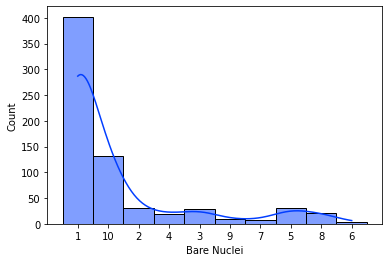

In [120]:
sns.histplot(data=df_bc['Bare Nuclei'][~(df_bc['Bare Nuclei'] == '?')], kde=True)

<img src="https://static.thenounproject.com/png/911566-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:darkblue; font-size: 16pt; font-weight:600">Inference</span>  
Since the data of 'Bare Nuclei' is heavily skewed and has outliers, the right approach to impute the missing values would be to use **MEDIAN**

In [121]:
# Creating a copy of the dataframe before changing the values
df = df_bc.copy(deep=True)

In [122]:
# Replacing all the '?' values with the median of the rest of the feature values
df['Bare Nuclei'][(df['Bare Nuclei'] == '?')] = df_bc['Bare Nuclei'][~(df_bc['Bare Nuclei'] == '?')].median()

In [123]:
# Updating the datatype of the 'Bare Nuclei' feature as all the values now are numeric.
df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei'], downcast='integer')

# OR df['Bare Nuclei'] = df['Bare Nuclei'].astype('int64')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   ID                           699 non-null    int64
 1   ClumpThickness               699 non-null    int64
 2   Cell Size                    699 non-null    int64
 3   Cell Shape                   699 non-null    int64
 4   Marginal Adhesion            699 non-null    int64
 5   Single Epithelial Cell Size  699 non-null    int64
 6   Bare Nuclei                  699 non-null    int8 
 7   Normal Nucleoli              699 non-null    int64
 8   Bland Chromatin              699 non-null    int64
 9   Mitoses                      699 non-null    int64
 10  Class                        699 non-null    int64
dtypes: int64(10), int8(1)
memory usage: 55.4 KB


***
Checking the distribution of the features

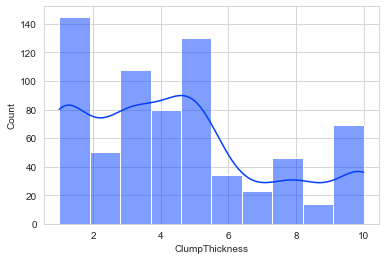

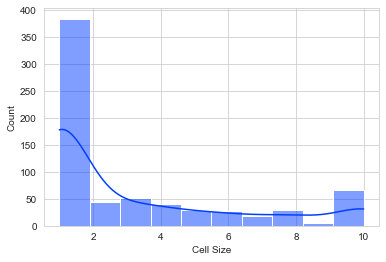

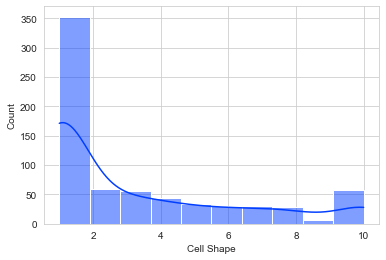

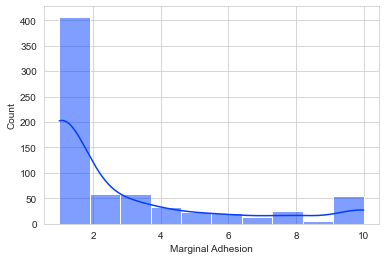

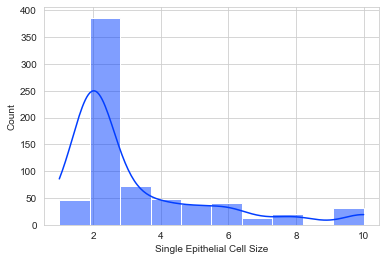

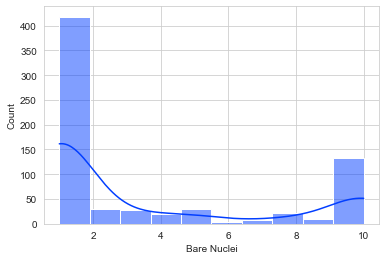

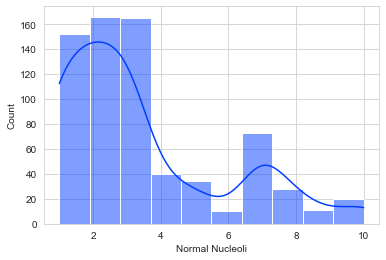

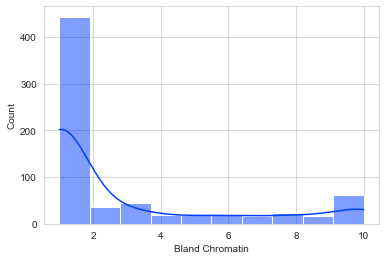

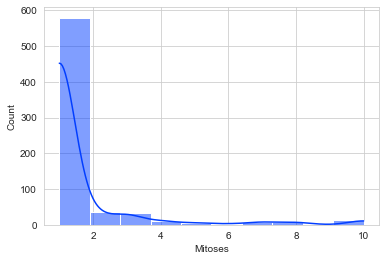

In [211]:
for col in df.columns[1:-1]:
    sns.histplot(data=df[col], kde=True, bins=10)
    plt.show()

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span>  
- All the features have non-normal distribution of data. 
- The data is heavily right skewed.
- This would need transforming the data to have better performing models.

Checking for **duplicate rows**

In [126]:
df[df.duplicated() == True]

,ID,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
208,1218860,1,1,1,1,1,1,3,1,1,2
253,1100524,6,10,10,2,8,10,7,3,3,4
254,1116116,9,10,10,1,10,8,3,3,1,4
258,1198641,3,1,1,1,2,1,3,1,1,2
272,320675,3,3,5,2,3,10,7,1,1,4
322,733639,3,1,1,1,2,1,3,1,1,2
338,704097,1,1,1,1,1,1,2,1,1,2
561,1321942,5,1,1,1,2,1,3,1,1,2
684,466906,1,1,1,1,2,1,1,1,1,2


<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span>  
- There are 9 rows whose data is duplicate.
- The _Duplicated_ function returns the rows whose data is duplicated.
- The duplicate data can be dropped.

<img src="https://static.thenounproject.com/png/247476-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:goldenrod; font-size: 16pt; font-weight:600">Suggestion</span>  
- Create a new dataframe with non-duplicate rows.
- Use the drop function to drop the ROWS using the INDEX function.

In [127]:
df_nd = df.drop(df[df.duplicated() == True].index)

In [128]:
df_nd.shape

(690, 11)

<img src="https://static.thenounproject.com/png/911566-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:darkblue; font-size: 16pt; font-weight:600">Inference</span>  
As expected, the number of rows in the new dataset is **9 less** than the original dataset.

In [129]:
# We can now remove the ID column also as it is not going to contribute to classification
df_nd.drop('ID', axis=1, inplace=True)

# Q4. Perform bi variate analysis including correlation, pairplots and state the inferences. 


In [130]:
# Check for correlation of variables

In [132]:
df_nd.corr()

,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
ClumpThickness,1.000000,0.643173,0.653589,0.487715,0.517253,0.590648,0.561063,0.535507,0.350196,0.716812
Cell Size,0.643173,1.000000,0.905349,0.712933,0.746982,0.684571,0.759632,0.727073,0.459918,0.817586
Cell Shape,0.653589,0.905349,1.000000,0.690782,0.714243,0.704165,0.738576,0.724519,0.440435,0.817551
Marginal Adhesion,0.487715,0.712933,0.690782,1.000000,0.608281,0.672512,0.669860,0.602228,0.417008,0.701175
Single Epithelial Cell Size,0.517253,0.746982,0.714243,0.608281,1.000000,0.580487,0.620526,0.633880,0.482517,0.681063
Bare Nuclei,0.590648,0.684571,0.704165,0.672512,0.580487,1.000000,0.672754,0.578161,0.342823,0.816655
Normal Nucleoli,0.561063,0.759632,0.738576,0.669860,0.620526,0.672754,1.000000,0.669099,0.343769,0.756736
Bland Chromatin,0.535507,0.727073,0.724519,0.602228,0.633880,0.578161,0.669099,1.000000,0.427490,0.715363
Mitoses,0.350196,0.459918,0.440435,0.417008,0.482517,0.342823,0.343769,0.427490,1.000000,0.423947
Class,0.716812,0.817586,0.817551,0.701175,0.681063,0.816655,0.756736,0.715363,0.423947,1.000000


<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span>  
- Cell shape and Cell size definitely have high correlation.
- Assuming a 70% threshold as high correlation, there is strong correlation between certain features.

<img src="https://static.thenounproject.com/png/247476-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:goldenrod; font-size: 16pt; font-weight:600">Suggestion</span>  

- It would make sense to drop the columns with very high correlations (0.9 and above)

In [179]:
# Creating a new dataframe with features having low multicollinearity
df_lc = drop_high_correlations(df_nd.iloc[:,:-1], 0.9)
df_lc['Class'] = df_nd['Class']

In [180]:
df_lc

,ClumpThickness,Cell Size,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
0,5,1,1,2,1,3,1,1,2
1,5,4,5,7,10,3,2,1,2
2,3,1,1,2,2,3,1,1,2
3,6,8,1,3,4,3,7,1,2
4,4,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...
694,3,1,1,3,2,1,1,1,2
695,2,1,1,2,1,1,1,1,2
696,5,10,3,7,3,8,10,2,4
697,4,8,4,3,4,10,6,1,4


The above dataframe is the one that we should now work with for further model creation.
***

<img src="https://static.thenounproject.com/png/911566-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:darkblue; font-size: 16pt; font-weight:600">Inference</span>  

The following features have good correlation (>0.7) with the outcome Class:
- Cell Size
- Cell Shape
- Bare Nuclei
- Normal Nucleoli
- ClumpThickness
- Bland Chromatin
- Marginal Adhesion'

In [181]:
#Let us check the pair plot

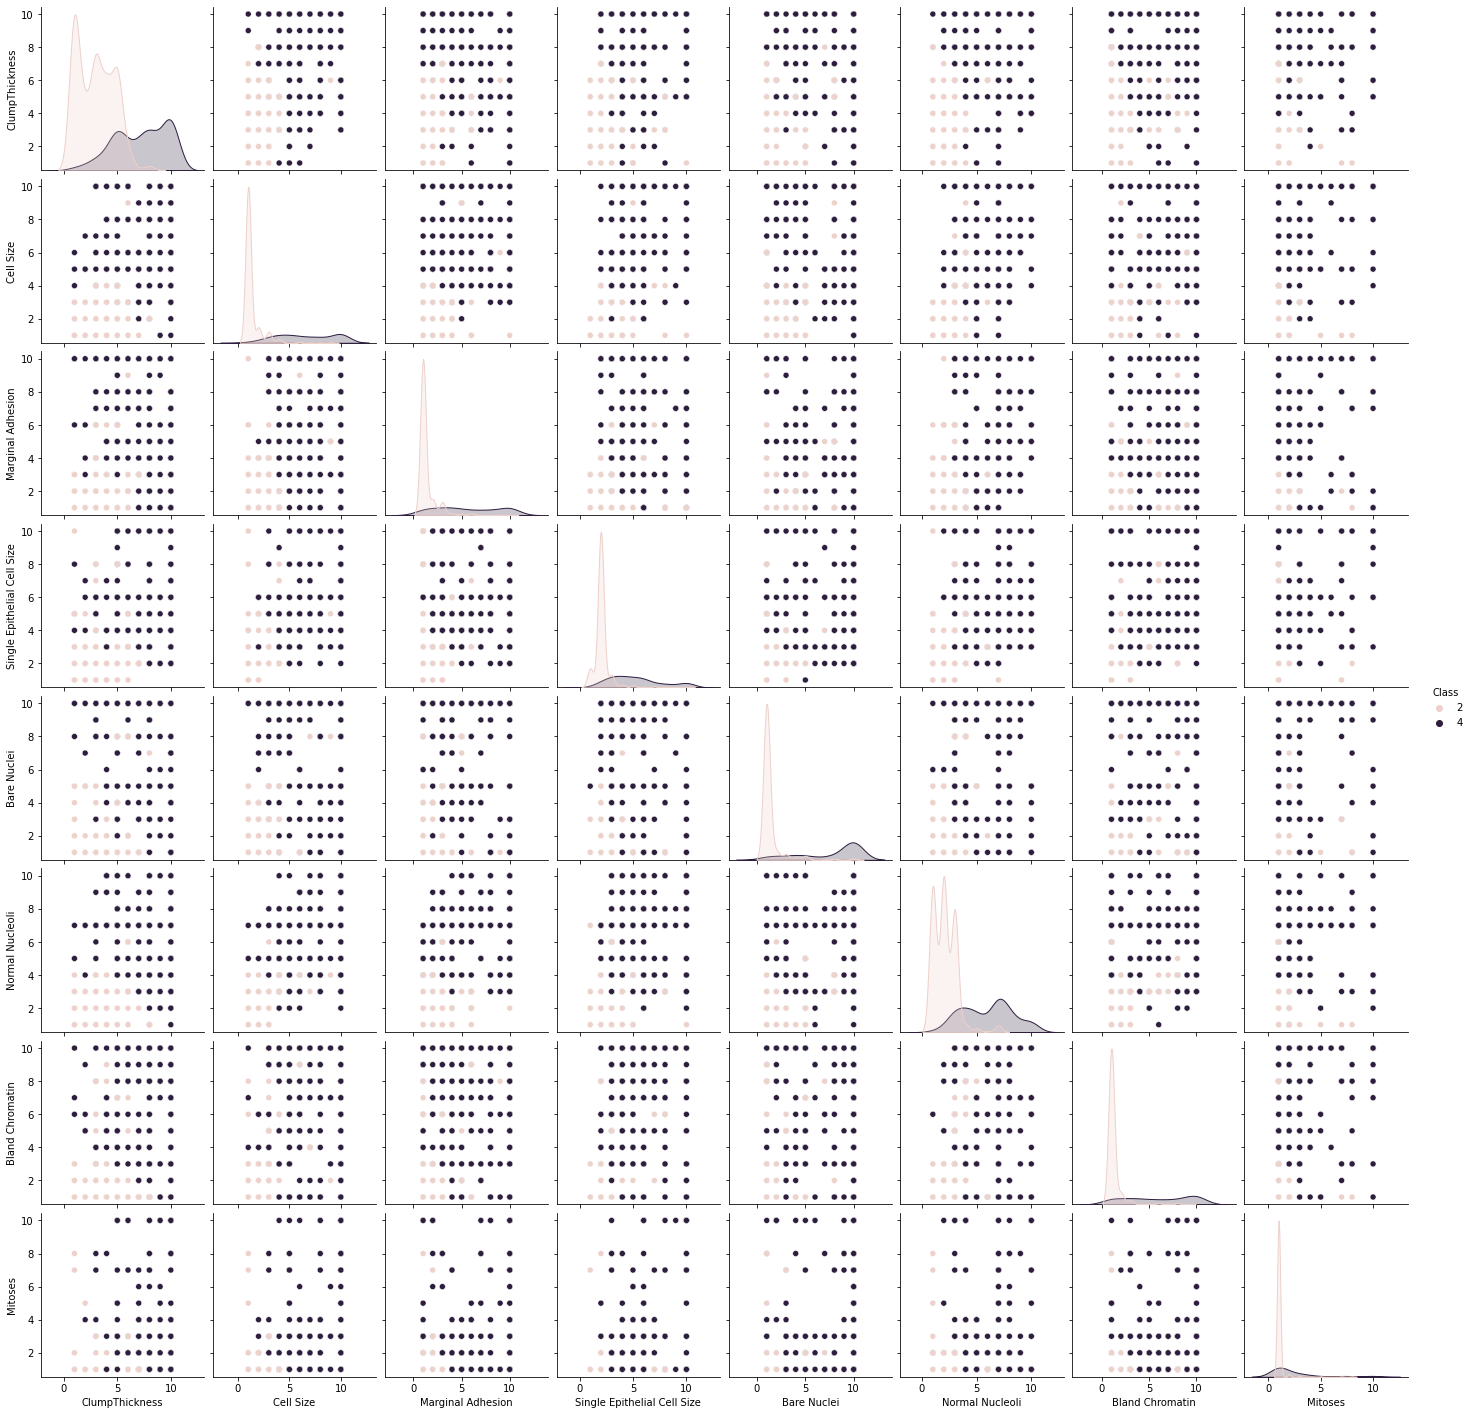

In [182]:
sns.set_palette('bright')
sns.pairplot(data=df_lc, diag_kind='kde', hue='Class')

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

- The KDE on the diagonals are showing distinct peaks for Class 0 and 1.
- Within each Class curve also we can see multiple peaks indicative of **further sub-groups within a class**.
- Being categorical features it is difficult to see a pattern of correlation between the variables.
- However, the hue of the Class is showing some distinction in the various plots.
- This is in-line with our previous observation that the features are able to contribute to identification of the differnt classes.
- Most of the distributions are right skewed, as observed earlier also.

### IMPORTANT:
Within the **Class-4** the Kurtosis of the values is very low. The data is highly dispersed especially for Cell Shape, Marginal Adhesion, Bland Chromation and Mitosis.

In [ ]:
# Relationship between variables shows come correlation. 
# Distribution of variables shows most of the values are concentrated on lower side, though range remains same for all that is 
# Between 1 to 10

# Q5 Remove any unwanted columns or outliers, standardize variables in pre-processing step

The unwanted columns such as ID and Cell Shape have already been removed.

<AxesSubplot:>

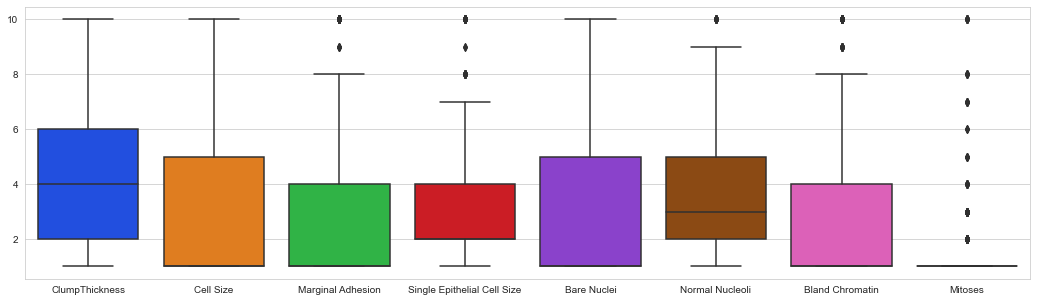

In [363]:
fig, ax = plt.subplots(1,figsize=(18,5))
sns.set_style("whitegrid") 
sns.boxplot(data = df_lc.iloc[:,:-1], ax=ax) 

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

The following columns have outliers and need to be treated:
- Marginal Adhesion
- Single Epitheleal Cell Size
- Normal Nucleoli
- Bland Chromatin
- Mitoses

<img src="https://static.thenounproject.com/png/247476-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:goldenrod; font-size: 16pt; font-weight:600">Suggestion</span>

Since the data is highly skewed , we can first apply a transformation to improve the distribution.  
If there are still any outliers, we can do capping.

In [401]:
df_Xformed = pd.DataFrame(preprocessing.quantile_transform(df_lc.drop('Class', axis=1),output_distribution='normal' ,random_state=76), columns=df_lc.drop('Class', axis=1).columns)
df_Xformed['Class'] = df_lc['Class']

<AxesSubplot:>

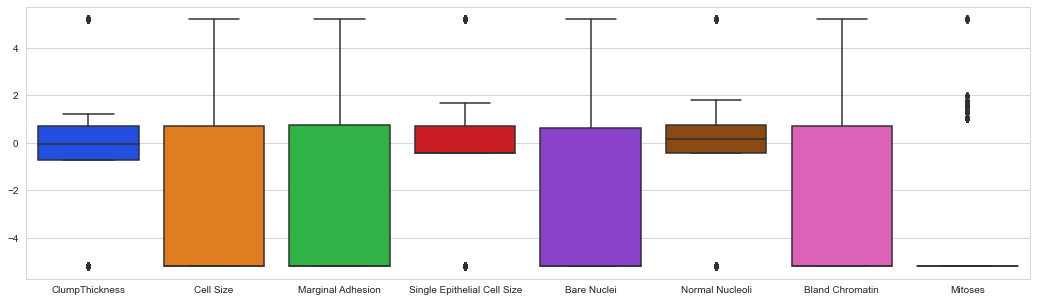

In [402]:
# Checking distribution of the data after applying the PowerTransform
fig, ax =plt.subplots(1,figsize=(18,5))
sns.set_style("whitegrid") 
sns.boxplot(data = df_Xformed.drop('Class', axis=1), ax=ax) 

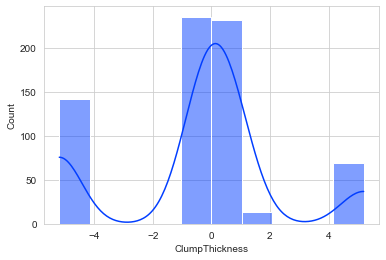

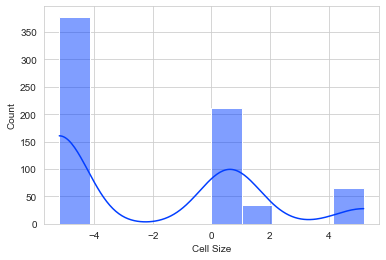

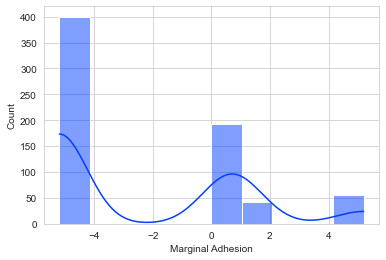

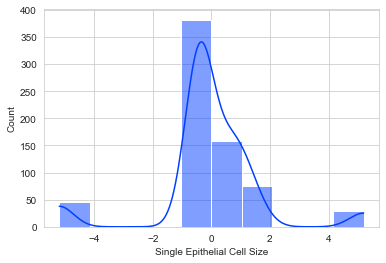

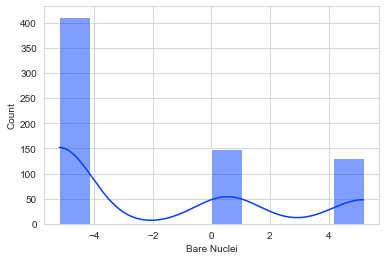

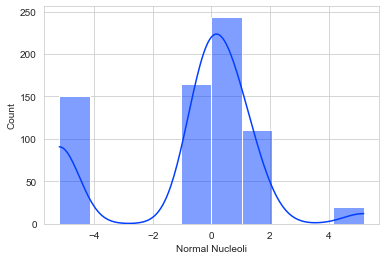

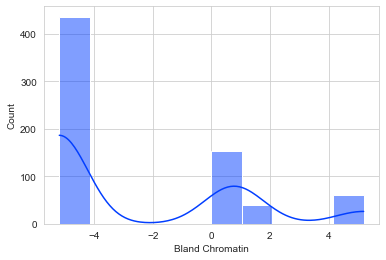

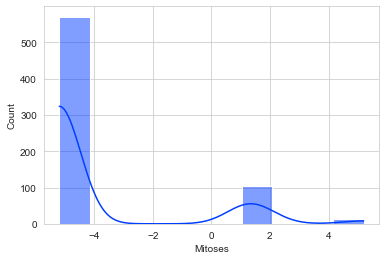

In [415]:
for col in df_Xformed.columns[:-1]:
    sns.histplot(data=df_Xformed[col], kde=True, bins=10)
    plt.show()

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

From the above boxplots it can be observed that there are still outliers. We need to check the actual distribution of values before addressing the outliers.  
The histograms indicate that the data has multiple **NORMALLY DISTRIBUTED** curves or Gaussians.

<img src="https://static.thenounproject.com/png/247476-200.png" alt="Idea" style="float: left; margin-right: 10px; width:35px" /><span style="color:goldenrod; font-size: 16pt; font-weight:600">Suggestion</span>

We can cap the values of outliers for he following features:
- Clump thickness
- Single Epithelial Cells
- Normal Nucleoli  

The outlier values can be capped to 1.5\*IQR + 75%ile values.  
One might question that capping values would result in a Gaussian getting created at the max value. However, the original data itself is highly skewed and _non-normally distributed_. Hence capping values in this manner would not cause any major harm.
### IMPORTANT:
Capping Mitoses data would not yield any results because the data for this feature is heavily concenterated around single value.

In [416]:
df_capped = df_Xformed.copy(deep=True)

In [417]:
df_capped['ClumpThickness'] = cap_outliers(df_Xformed['ClumpThickness'],0)

In [418]:
df_capped['Single Epithelial Cell Size'] = cap_outliers(df_Xformed['Single Epithelial Cell Size'],0)

In [419]:
df_capped['Normal Nucleoli'] = cap_outliers(df_Xformed['Normal Nucleoli'],0)

<AxesSubplot:>

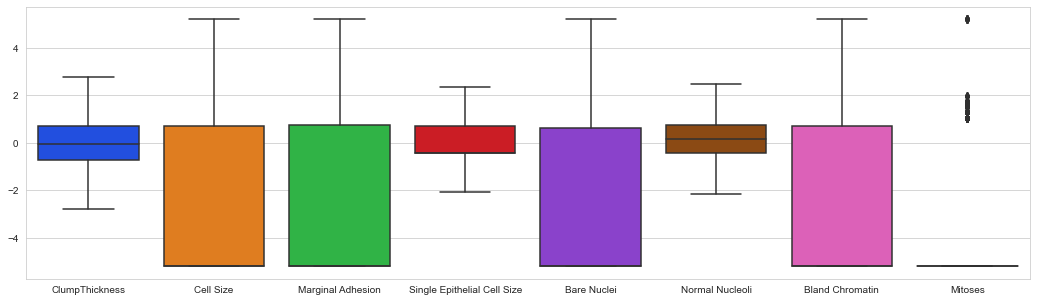

In [420]:
# Checking distribution of the data after capping the outliers.
fig, ax = plt.subplots(1,figsize=(18,5))
sns.set_style("whitegrid") 
sns.boxplot(data = df_capped.iloc[:,:-1], ax=ax) 

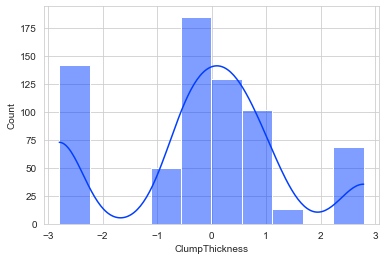

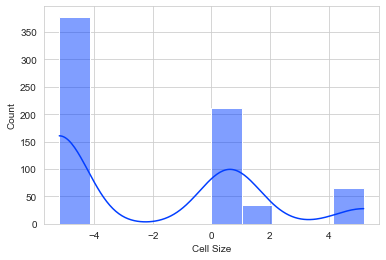

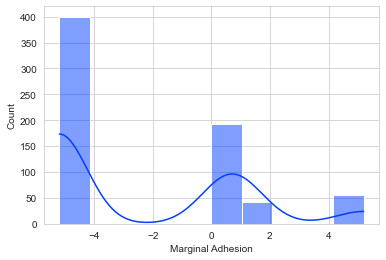

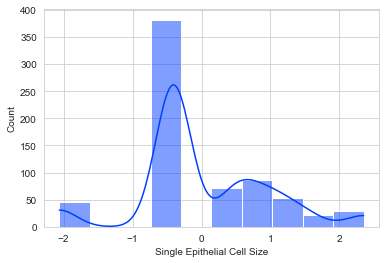

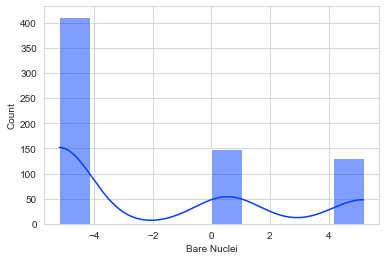

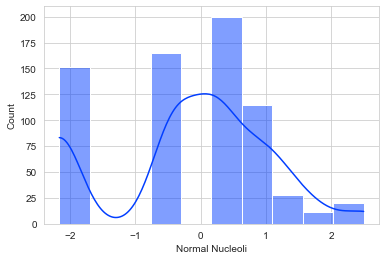

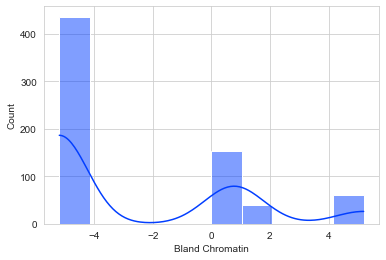

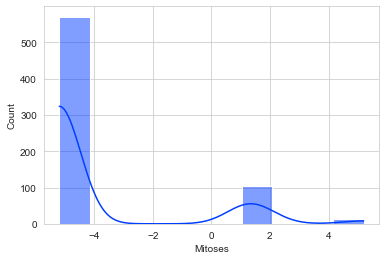

In [422]:
for col in df_capped.columns[:-1]:
    sns.histplot(data=df_capped[col], kde=True, bins=10)
    plt.show()

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

We can see that there are no outliers anymore.  
Some of the features have a good normal distribution.  
However, some of the features are still highly skewed

# Q6 Create a covariance matrix for identifying Principal components

In [466]:
# PCA
# Step 1 - Create covariance matrix

In [425]:
df_capped_cov = df_capped.iloc[:,:-1].cov()

In [435]:
df_capped_cov

,ClumpThickness,Cell Size,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses
ClumpThickness,2.585056,3.370067,2.700914,0.761124,3.480039,0.906195,2.787980,1.630737
Cell Size,3.370067,13.021505,8.749410,2.388466,10.443809,2.784247,9.187176,4.784378
Marginal Adhesion,2.700914,8.749410,12.501848,1.954729,9.785027,2.352361,7.417900,4.294465
Single Epithelial Cell Size,0.761124,2.388466,1.954729,0.903858,2.403694,0.625058,2.160760,1.193016
Bare Nuclei,3.480039,10.443809,9.785027,2.403694,17.299774,3.028844,8.987270,5.218864
Normal Nucleoli,0.906195,2.784247,2.352361,0.625058,3.028844,1.555973,2.663104,1.131844
Bland Chromatin,2.787980,9.187176,7.417900,2.160760,8.987270,2.663104,12.874782,4.797032
Mitoses,1.630737,4.784378,4.294465,1.193016,5.218864,1.131844,4.797032,7.299650


# Q7 Identify eigen values and eigen vector

In [436]:
# Step 2- Get eigen values and eigen vector

In [437]:
eig_vals,eig_vecs=np.linalg.eig(df_capped_cov)

In [438]:
eig_vals

array([46.17753386,  0.39530566,  0.80542677,  1.56486939,  6.226052  ,
        3.39398007,  4.66969682,  4.8095814 ])

In [439]:
eig_vecs

array([[ 1.47876372e-01, -4.89713654e-02, -9.79135924e-02,
         9.67951583e-01,  1.52765710e-02,  1.68886361e-01,
         1.82257687e-02,  1.13529660e-02],
       [ 4.73154207e-01, -8.31089722e-02, -7.54488611e-02,
        -2.25174292e-01,  1.73594692e-01,  7.83443361e-01,
         1.95264971e-01, -1.75427983e-01],
       [ 4.33295481e-01, -1.90234557e-02, -2.67339971e-02,
         6.29103847e-04, -2.24263994e-01, -2.96281997e-01,
        -3.47298289e-01, -7.43293058e-01],
       [ 1.03742093e-01,  9.91580671e-01,  4.13486409e-02,
         3.00178905e-02,  3.62042559e-02,  4.40937319e-02,
         1.18075119e-02, -3.80818385e-04],
       [ 5.37770671e-01, -2.37524114e-02, -6.17990283e-02,
        -6.38884199e-02, -6.44876727e-01, -1.39661662e-01,
         1.63306387e-01,  4.90201316e-01],
       [ 1.25604369e-01, -5.84033844e-02,  9.83433733e-01,
         7.44647989e-02,  1.88914233e-02,  5.95225448e-03,
         8.74233650e-02, -9.51391306e-03],
       [ 4.36640685e-01, -4.712523

In [444]:
np.sort(eig_vals)

array([ 0.39530566,  0.80542677,  1.56486939,  3.39398007,  4.66969682,
        4.8095814 ,  6.226052  , 46.17753386])

# Q8 Find variance and cumulative variance by each eigen vector

In [442]:
# Get total of the Eigen Values
tot = sum(eig_vals)

# Create an array of Eigen Values as % of Total Eigen Values with these %ages in increasing order
var_exp = [(i/tot) * 100 for i in sorted(eig_vals, reverse=True)]

# Create an array of cumulative sum of the % values
cum_var_exp = np.cumsum(var_exp)
print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 67.86577584  77.01602302  84.08452466  90.947442    95.93547559
  98.23531854  99.41903079 100.        ]


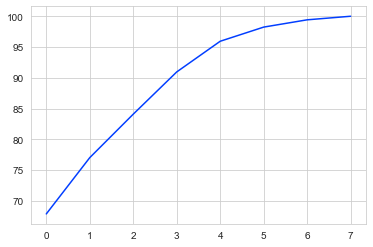

In [443]:
plt.plot(cum_var_exp)

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

The Eigen values curve indicates that there is not much gain from PC-4 to PC-5

# Q9 Use PCA command from sklearn and find Principal Components. Transform data to components formed

Using the sklearn PCA to find Principal Compnents

In [471]:
pca = PCA()
X_vals = pca.fit_transform(df_capped.drop('Class', axis=1))
df_pca = pd.DataFrame(data=pca.components_, columns=df_capped.drop('Class', axis=1).columns)
df_pca['Class'] = df_capped['Class']
df_pca

,ClumpThickness,Cell Size,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
0,0.147876,0.473154,0.433295,0.103742,0.537771,0.125604,0.436641,0.245197,2.0
1,0.015277,0.173595,-0.224264,0.036204,-0.644877,0.018891,0.645028,0.292818,2.0
2,-0.011353,0.175428,0.743293,0.000381,-0.490201,0.009514,-0.093076,-0.409342,2.0
3,-0.018226,-0.195265,0.347298,-0.011808,-0.163306,-0.087423,-0.359831,0.822796,2.0
4,0.168886,0.783443,-0.296282,0.044094,-0.139662,0.005952,-0.493104,0.072624,2.0
5,-0.967952,0.225174,-0.000629,-0.030018,0.063888,-0.074465,0.011038,0.041427,4.0
6,0.097914,0.075449,0.026734,-0.041349,0.061799,-0.983434,0.098224,-0.041073,2.0
7,-0.048971,-0.083109,-0.019023,0.991581,-0.023752,-0.058403,-0.047125,-0.030078,2.0


# Q10 Find correlation between components and features

Performing the univariate and bivariate analysis on the newly reated dataframe of Principal Components

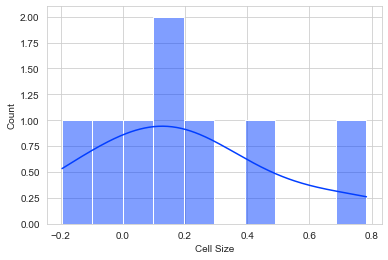

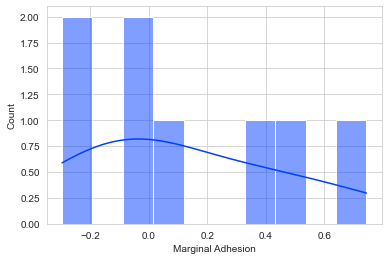

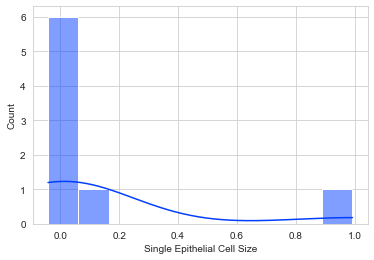

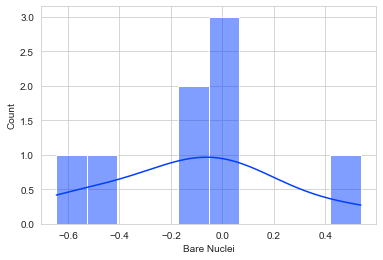

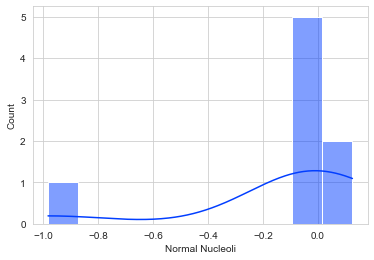

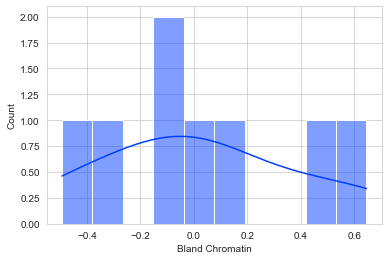

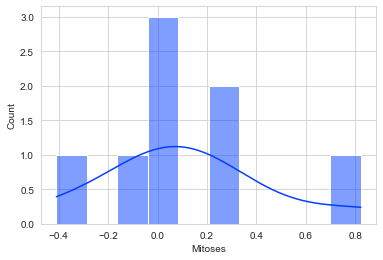

In [472]:
for col in df_pca.columns[1:-1]:
    sns.histplot(data=df_pca[col], kde=True, bins=10)
    plt.show()

<AxesSubplot:>

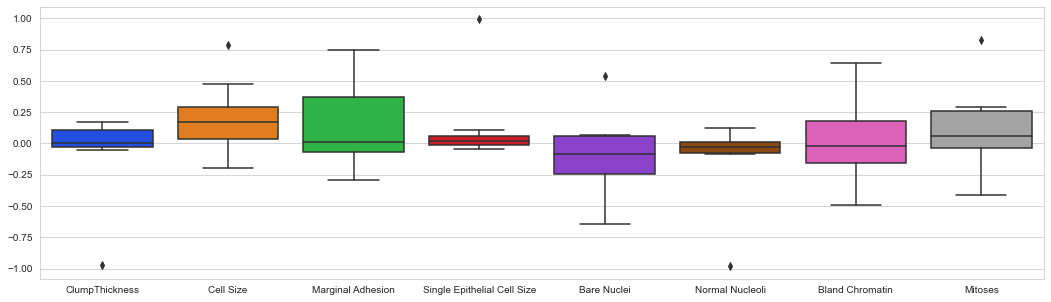

In [473]:
# Checking distribution of the data after capping the outliers.
fig, ax = plt.subplots(1,figsize=(18,5))
sns.set_style("whitegrid") 
sns.boxplot(data = df_pca.iloc[:,:-1], ax=ax) 

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

The histograms above show that the data is much better distributed now as compared to the original distribution.  
The original distribution was highly right skewed. The current distribution is tending towards normal distribution.  
The box plots are indicating narrow distribution of data with very few outliers.

In [476]:
df_pca.corr()

,ClumpThickness,Cell Size,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
ClumpThickness,1.000000,0.157194,0.085428,0.093564,-0.065715,-0.088683,0.015658,0.083877,-0.975861
Cell Size,0.157194,1.000000,-0.269182,-0.294819,0.207068,0.279439,-0.049337,-0.264297,0.028355
Marginal Adhesion,0.085428,-0.269182,1.000000,-0.160221,0.112532,0.151862,-0.026813,-0.143634,-0.145283
Single Epithelial Cell Size,0.093564,-0.294819,-0.160221,1.000000,0.123250,0.166326,-0.029366,-0.157313,-0.193123
Bare Nuclei,-0.065715,0.207068,0.112532,0.123250,1.000000,-0.116820,0.020626,0.110490,0.182399
Normal Nucleoli,-0.088683,0.279439,0.151862,0.166326,-0.116820,1.000000,0.027834,0.149106,0.064419
Bland Chromatin,0.015658,-0.049337,-0.026813,-0.029366,0.020626,0.027834,1.000000,-0.026326,-0.014667
Mitoses,0.083877,-0.264297,-0.143634,-0.157313,0.110490,0.149106,-0.026326,1.000000,-0.094631
Class,-0.975861,0.028355,-0.145283,-0.193123,0.182399,0.064419,-0.014667,-0.094631,1.000000


<AxesSubplot:>

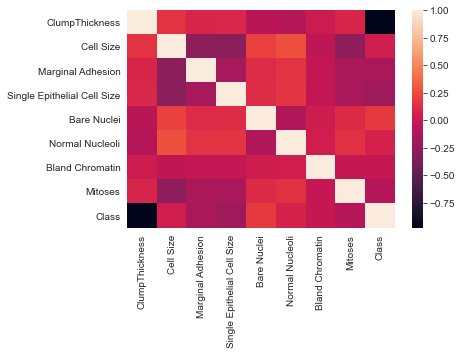

In [475]:
sns.heatmap(df_pca.corr())

<img src="https://static.thenounproject.com/png/2848201-200.png" alt="Observations" style="float: left; margin-right: 10px; width:35px" /><span style="color:green; font-size: 16pt; font-weight:600">Observation</span> 

The above correlation table and the heatmap shows that:
- The features do not have high correlation with each other which is *good*  
- The _Clump Thickness_ feature has **very high negative correlation** with the outcome class. In fact this is the only feature with high correlation. Rest other features' correlation has reduced from about 0.7 to 0.15. This is because of **Principal Component Analysis**.